<a href="https://colab.research.google.com/github/sammylina/alx_final_portfolio/blob/master/cnn_amharic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drived')

Mounted at /content/drived


In [2]:
import tarfile

file_path = '/content/drived/MyDrive/amharic_dataset_full.tar.gz'
dest_path = '/content/amharic_dataset_full'

with tarfile.open(file_path, 'r:gz') as f:
    f.extractall(dest_path)

In [3]:
# Create Amharic dataset class

from torch.utils.data import Dataset
from PIL import Image
import os
import torch

class AmharicDataset(Dataset):
    def __init__(self, img_folder, transform=None, train=True, test_split=0.2):
        # Load image
        self.img_folder = img_folder
        self.transform = transform
        self.file_list = os.listdir(img_folder)

        self.train = train
        self.test_split = test_split
        self.split_idx = int(len(self.file_list) * (1 - self.test_split))

        # Create labels from file name
        self.labels = [int(f_name[:3])for f_name in self.file_list]



    def __len__(self):
        if self.train:
            return self.split_idx
        return len(self.file_list) - self.split_idx

    def __getitem__(self, idx):
        if self.train:
            file_name = self.file_list[idx]
            label = self.labels[idx]
        else:
            file_name = self.file_list[idx + self.split_idx]
            label = self.labels[idx + self.split_idx]

        file_path = os.path.join(self.img_folder, file_name)
        sample = Image.open(file_path)


        if (self.transform):
            sample = self.transform(sample)

        return sample, label

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
import torch.nn as nn

In [5]:
# Load data to torch loader


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_data = AmharicDataset('/content/amharic_dataset_full/amharic_dataset_full', transform=transform, train=True)
test_data = AmharicDataset('/content/amharic_dataset_full/amharic_dataset_full', transform=transform, train=False)

valid_size = 0.15

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, sampler=train_sampler, batch_size =16)
valid_loader = DataLoader(train_data, sampler=valid_sampler, batch_size=16)
test_loader = DataLoader(test_data, batch_size=16)



torch.Size([1, 28, 28])
Label: 78
Char: ተ
Unicode: 4720


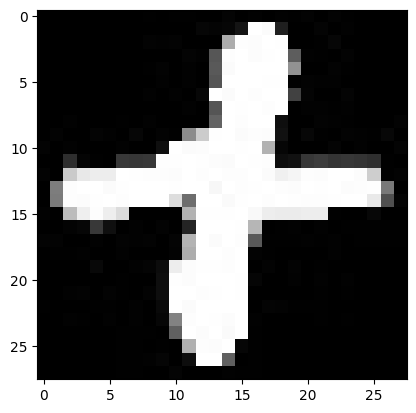

In [7]:
# visualize image data and label
import matplotlib.pyplot as plt
import numpy as np

data, label = next(iter(valid_loader))

img = data[0]
lab = label[0]
print(img.shape)

def label_to_char(label):

    start = ord('ሀ')
    end = ord('ፐ')

    bad_chars = [4680, 4688, 4696, 4744, 4784, 4800, 4856, 4880, 4888]
    m = [char_code for char_code in range(start, end + 1, 8) if char_code not in bad_chars]

    row, col = None, None
    if label % 7 == 0:
        col = 6
        row = int(label / 7) - 1
    else:
        col = (label % 7) - 1
        row = label // 7

    return m[row] + col

img_np = img.squeeze().numpy()
uc = label_to_char(lab.item())
print(f'Label: {lab.item()}')
print(f'Char: {chr(uc)}')
print(f'Unicode: {uc}')
plt.imshow(img_np, cmap='gray')

In [8]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('Training on GPU')
else:
    print('GPU not available')

Training on GPU


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(576, 256)
        self.fc2 = nn.Linear(256, 239)

        self.dropout = nn.Dropout(0.35)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # we have (14 x 14 x 16)
        x = self.pool(F.relu(self.conv2(x))) # we have (7 x 7 x 32)
        x = self.pool(F.relu(self.conv3(x))) # we have (3 x 3 x 64)

        x = x.view(-1, 3 * 3 * 64)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        return self.fc2(x)


l_model = LeNet()
print(l_model)

if train_on_gpu:
    l_model.cuda()



LeNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=239, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)


In [10]:
import torch.optim as optim

epoch = 35
lr = 0.001
valid_loss_min = np.Inf

model = LeNet()
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


for ep in range(1, epoch + 1):

    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, label in train_loader:

        if train_on_gpu:
            data, label = data.cuda(), label.cuda()

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)


    model.eval()
    acc = 0.0
    for v_data, v_label in valid_loader:
        if train_on_gpu:
            v_data, v_label = v_data.cuda(), v_label.cuda()

        ouputs = model(v_data)

        loss = criterion(ouputs, v_label)

        valid_loss += loss.item() * v_data.size(0)

        _, pred = torch.max(ouputs, 1)
        acc += (pred == v_label).sum().item()

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)


    print(f'({ep}) train_loss: {train_loss:.3f} valid_loss: {valid_loss:.3f} acc: {acc / len(valid_loader.sampler):.2f}%')

    if valid_loss < valid_loss_min:
        print(f'Validation loss decreased from ===> {valid_loss_min:.3f} - {valid_loss:.3f}, saving model...')
        torch.save(model.state_dict(), f'best_model.pth')
        valid_loss_min = valid_loss


(1) train_loss: 2.921 valid_loss: 1.062 acc: 0.69%
Validation loss decreased from ===> inf - 1.062, saving model...
(2) train_loss: 1.292 valid_loss: 0.703 acc: 0.79%
Validation loss decreased from ===> 1.062 - 0.703, saving model...
(3) train_loss: 0.997 valid_loss: 0.574 acc: 0.82%
Validation loss decreased from ===> 0.703 - 0.574, saving model...
(4) train_loss: 0.860 valid_loss: 0.531 acc: 0.83%
Validation loss decreased from ===> 0.574 - 0.531, saving model...
(5) train_loss: 0.763 valid_loss: 0.477 acc: 0.85%
Validation loss decreased from ===> 0.531 - 0.477, saving model...
(6) train_loss: 0.706 valid_loss: 0.461 acc: 0.85%
Validation loss decreased from ===> 0.477 - 0.461, saving model...
(7) train_loss: 0.658 valid_loss: 0.446 acc: 0.86%
Validation loss decreased from ===> 0.461 - 0.446, saving model...
(8) train_loss: 0.621 valid_loss: 0.431 acc: 0.86%
Validation loss decreased from ===> 0.446 - 0.431, saving model...
(9) train_loss: 0.601 valid_loss: 0.421 acc: 0.87%
Validat

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint = '/content/best_model.pth'

model = LeNet()

model.to(device)
model.load_state_dict(torch.load(checkpoint, map_location=torch.device(device)))


<All keys matched successfully>

In [14]:
test_loss = 0.0
correct_pred = 0
total_sample = 0
model.eval()
for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    outputs = model(data)
    loss = criterion(outputs, target)

    test_loss += loss.item() * data.size(0)

    _, pred = torch.max(outputs, 1)
    total_sample += target.size(0)
    correct_pred += (pred == target).sum().item()

# average test loss
test_loss = test_loss/total_sample
accuracy = correct_pred / total_sample
print(f'test loss {test_loss:.3f}  acc... {accuracy:.3f}')



test loss 0.393  acc... 0.870


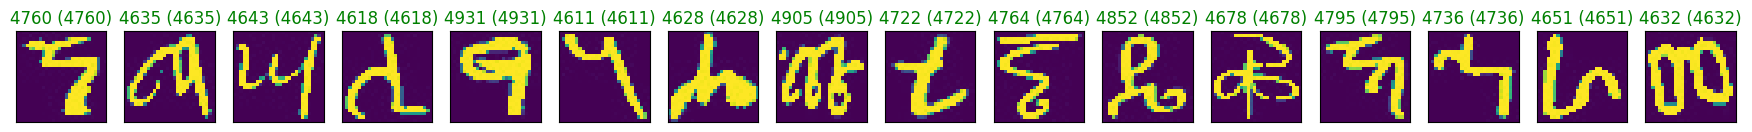

In [15]:
images, labels = next(iter(train_loader))
images.numpy()

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Glyph")

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, pred = torch.max(output, 1)


preds = np.squeeze(pred.numpy()) if not train_on_gpu else np.squeeze(pred.cpu().numpy())

import matplotlib.pyplot as plt

classes = {l: label_to_char(l) for l in range(1, 239)}

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2,18, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    p, a = classes[preds[idx]], classes[labels[idx].item()]
    if preds[idx] != labels[idx].item():
        print(f'predicted: {chr(p)}, actual {chr(a)}')
    ax.set_title(f"{p} ({a})",
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
